In [29]:
# compare baseline-model, one with just demographics, one with linguistic features, one with acoustic features, one with linguistic + acoustic and a full model with all features

# setup
import sys
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from regression.regression_functions import stratified_cross_validation

# paths
task_name = "cookieTheft"
target = "SemanticFluencyScore"
features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered.csv")
scores_path = os.path.join(GIT_DIRECTORY, f"data/language_scores_all_subjects.csv")
demographics_path = os.path.join(GIT_DIRECTORY, f"data/demographics_data.csv")
folds_path = os.path.join(GIT_DIRECTORY, "data", f"{task_name}_stratified_folds.csv")

# load data
features = pd.read_csv(features_path)
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)
folds = pd.read_csv(folds_path)

In [30]:
# prepare demographics

# encode Gender: f (female) = 0, m (male) = 1
demographics["Gender"] = demographics["Gender"].map({"f": 0, "m": 1})

# encode Education
education_map = {
    "less_than_highschool": 1,
    "high_school": 2,
    "vocational": 3,
    "bachelor": 4,
    "master": 5,
    "phd": 6,
    "no_answer": np.nan
}
demographics["Education"] = demographics["Education"].map(education_map)

# encode Country: uk = 0, usa = 1
demographics["Country"] = demographics["Country"].map({"uk": 0, "usa": 1})

# drop Language (same information as Country)
demographics.drop(columns=["Language"], inplace=True)

# Socioeconomic is already 1-10


In [31]:
# merge scores and features
df = pd.merge(features, scores[["Subject_ID", target]], on="Subject_ID")
df = pd.merge(df, demographics, on="Subject_ID")
df = pd.merge(df, folds[["Subject_ID", "fold"]], on="Subject_ID")

# define feature sets
demographic_cols = ["Age", "Gender", "Education", "Country", "Socioeconomic"]
linguistic_cols = df.columns[1:33].tolist()
acoustic_cols = df.columns[33:].tolist()

model_configs = {
    "baseline": [],
    "demographics": demographic_cols,
    "linguistic": linguistic_cols,
    "acoustic": acoustic_cols,
    "linguistic+acoustic": linguistic_cols + acoustic_cols,
    "full": demographic_cols + linguistic_cols + acoustic_cols
}

In [32]:
# loop over model types
results = []
fold_results = []

for model_name, cols in model_configs.items():
    print(f"running model: {model_name} with {len(cols)} features")

    # make sure fold, ID, or target aren't accidentally used as features
    cols = [c for c in cols if c not in ["Subject_ID", "fold", target]]

    # this part is to drop missing values because it causes an error otherwise -> might delete that if I'm choosing imputation later
    # clean X and y for current model
    X_clean = df[cols].copy() if cols else pd.DataFrame(np.ones((len(df), 1)), columns=["intercept"])
    y_clean = df[target].copy()
    meta = df[["Subject_ID", "fold"]].copy()
    # combine into model_df
    model_df = pd.concat([meta, X_clean, y_clean.rename(target)], axis=1)
    # track and drop NaNs
    before_ids = set(model_df["Subject_ID"])
    model_df = model_df.dropna()
    after_ids = set(model_df["Subject_ID"])
    dropped_ids = before_ids - after_ids
    # print what subjects where dropped
    print(f"{len(dropped_ids)} rows dropped due to NaNs in model '{model_name}':")
    print(sorted(dropped_ids))
    # final clean X and y
    X = model_df[cols] if cols else pd.DataFrame(np.ones((len(df), 1)), columns=["intercept"])
    y = model_df[target]

    # run stratified cross-validation
    r2_list, rmse_list, mae_list, all_preds = stratified_cross_validation(
        df=model_df,
        fold_column="fold",
        model_class=LinearRegression,
        model_params=None,
        target_column=target,
        feature_columns=X.columns,
        model_name=model_name
    )

    # for plot later
    for fold in all_preds["fold"].unique():
        r2_fold = r2_score(
            all_preds.loc[all_preds["fold"] == fold, "y_test"],
            all_preds.loc[all_preds["fold"] == fold, "y_pred"]
        )
        fold_results.append({
            "model": model_name,
            "fold": fold,
            "r2": r2_fold
        })

    # calculate statistics
    r2_mean = np.mean(r2_list)
    r2_std = np.std(r2_list)
    r2_se = r2_std / np.sqrt(len(r2_list))
    r2_ci_low = r2_mean - 1.96 * r2_se
    r2_ci_high = r2_mean + 1.96 * r2_se

    # save results
    results.append({
        "model": model_name,
        "r2_mean": r2_mean,
        "r2_std": r2_std,
        "r2_se": r2_se,
        "r2_ci_low": r2_ci_low,
        "r2_ci_high": r2_ci_high,
        "rmse_mean": np.mean(rmse_list),
        "mae_mean": np.mean(mae_list)
    })

# for plot later
df_folds = pd.DataFrame(fold_results)

# save overview
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(GIT_DIRECTORY, "results", "regression", "model_comparison", f"{task_name}_{target}_model_comparison.csv"), index=False)
results_df

running model: baseline with 0 features
1 rows dropped due to NaNs in model 'baseline':
[99]
Fold 1: R² = -0.005, RMSE = 5.95, MAE = 4.73
Fold 2: R² = -0.002, RMSE = 5.58, MAE = 4.42
Fold 3: R² = -0.007, RMSE = 5.29, MAE = 4.33
Fold 4: R² = -0.016, RMSE = 5.96, MAE = 4.63
Fold 5: R² = -0.000, RMSE = 5.65, MAE = 4.51
running model: demographics with 5 features
1 rows dropped due to NaNs in model 'demographics':
[99]
Fold 1: R² = 0.037, RMSE = 5.82, MAE = 4.59
Fold 2: R² = 0.055, RMSE = 5.42, MAE = 4.26
Fold 3: R² = 0.074, RMSE = 5.07, MAE = 4.14
Fold 4: R² = 0.096, RMSE = 5.62, MAE = 4.31
Fold 5: R² = 0.092, RMSE = 5.38, MAE = 4.21
running model: linguistic with 32 features
41 rows dropped due to NaNs in model 'linguistic':
[99, 138, 141, 143, 157, 163, 190, 198, 381, 385, 389, 469, 492, 500, 516, 585, 623, 626, 648, 724, 871, 893, 921, 938, 944, 957, 1065, 1112, 1130, 1155, 1169, 1222, 1223, 1257, 1258, 1276, 1298, 1308, 1315, 1318, 1361]
Fold 1: R² = 0.048, RMSE = 5.55, MAE = 4.34
Fol

,model,r2_mean,r2_std,r2_se,r2_ci_low,r2_ci_high,rmse_mean,mae_mean
0,baseline,-0.006030,0.005548,0.002481,-0.010893,-0.001167,5.686029,4.523210
1,demographics,0.071117,0.022298,0.009972,0.051572,0.090662,5.463357,4.301719
2,linguistic,-0.059187,0.286728,0.128229,-0.310515,0.192141,5.699304,4.240579
3,acoustic,0.025152,0.250769,0.112147,-0.194656,0.244961,5.554067,4.196219
4,linguistic+acoustic,-0.085179,0.460070,0.205749,-0.488448,0.318090,5.711814,4.107510
5,full,-0.085179,0.460070,0.205749,-0.488448,0.318090,5.711814,4.107510


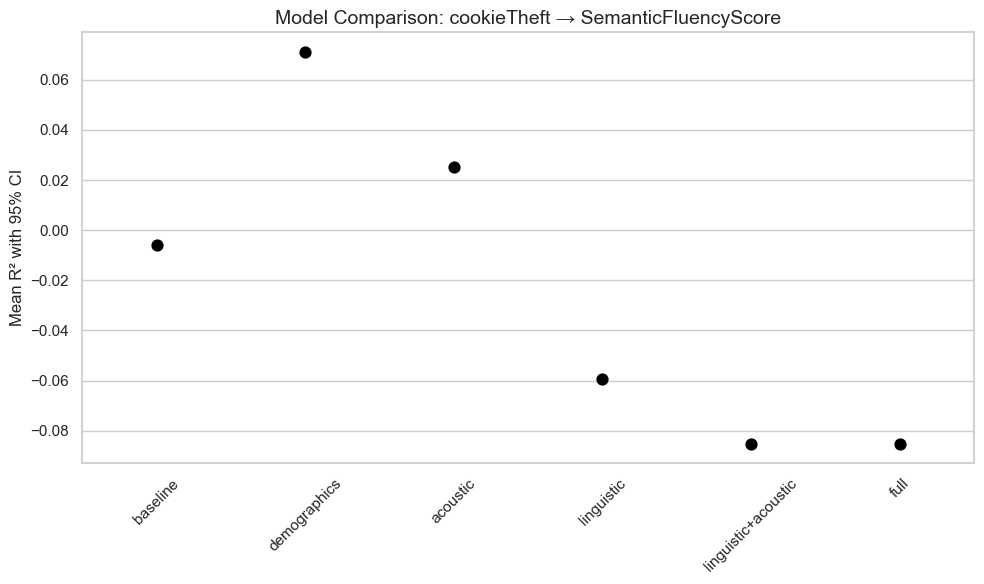

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# define custom model order
model_order = ["baseline", "demographics", "acoustic", "linguistic", "linguistic+acoustic", "full"]

# enforce categorical order in both DataFrames
cat_type = CategoricalDtype(categories=model_order, ordered=True)
results_df["model"] = results_df["model"].astype(cat_type)
df_folds["model"] = df_folds["model"].astype(cat_type)

sns.set(style="whitegrid")

# sort (optional)
results_df_sorted = results_df.sort_values("r2_mean", ascending=False)

# create plot
plt.figure(figsize=(10, 6))
ax = sns.pointplot(
    data=results_df_sorted,
    x="model",
    y="r2_mean",
    errorbar=("ci", 95),
    capsize=0.2,
    color="black",
    err_kws={"linewidth": 1.5},
    markers="o",
    linestyles="none"
)

# annotate
plt.title(f"Model Comparison: {task_name} → {target}", fontsize=14)
plt.ylabel("Mean R² with 95% CI")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()

# save
plt.savefig(os.path.join(
    GIT_DIRECTORY,
    "results",
    "regression",
    "model_comparison",
    f"{task_name}_{target}_model_comparison_pointplot.png"
))
plt.show()

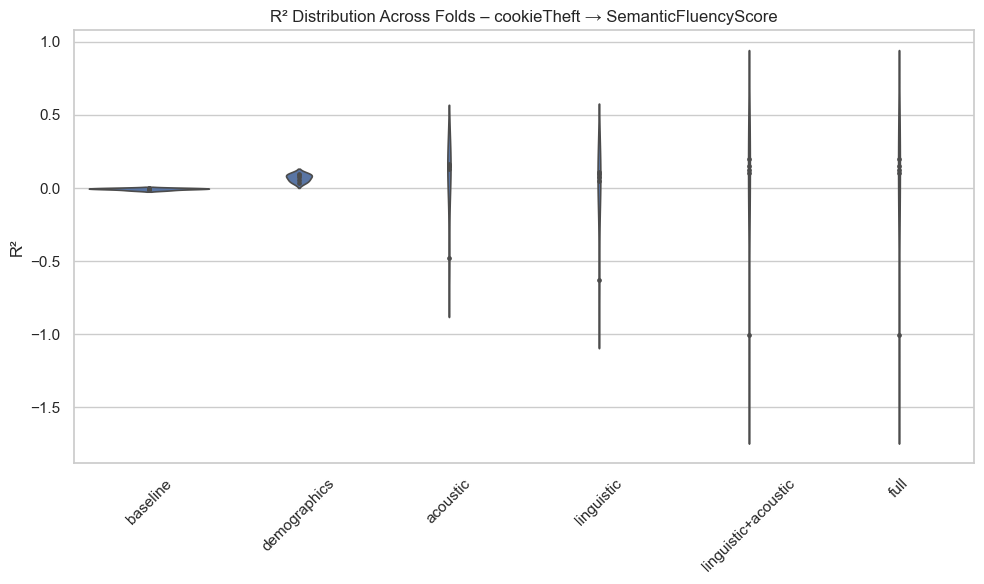

In [34]:
# violin plot for models
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_folds, x="model", y="r2", inner="point", linewidth=1.2)
plt.title(f"R² Distribution Across Folds – {task_name} → {target}")
plt.ylabel("R²")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(GIT_DIRECTORY, "results", "regression", "model_comparison", f"{task_name}_{target}_r2_violinplot.png"))
plt.show()